<br>

### Import Libraries

In [24]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())

2.8.0+cu129
True


<br>

### Pretrained Model

In [27]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
import os
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
# Load pretrained ViT model
model_name = "google/vit-base-patch16-224-in21k"  # pretrained on ImageNet21k
# change num_labels to number of classes in your dataset
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(os.listdir(r"archive/Vehicles")))
 
# move model to device(GPU)
model.to(device)
 
# Feature extractor (for normalization)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
c:\Users\sirom\miniconda3\envs\torch129\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


<br>

### Transformers

In [30]:
from torchvision import datasets, transforms
from torch.utils.data import random_split
 
""" 
ViT pretrained models were trained on 224×224 images, so the positional embeddings are fixed for that size.
"""
 
transform = transforms.Compose([
    # resize to 224x224
    transforms.Resize((224, 224)), 
    # convert image to tensor
    transforms.ToTensor(),  
    # normalize using feature extractor parameters
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])
 
# load all data, change "archive/Vehicles" to your dataset path
full_dataset = datasets.ImageFolder("archive/Vehicles", transform=transform)
 
# split ratio
val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size
 
train_data, validation_data = random_split(full_dataset, [train_size, val_size])

train_data, validation_data

(<torch.utils.data.dataset.Subset at 0x29d8416df60>,
 <torch.utils.data.dataset.Subset at 0x29d8416e920>)

In [31]:
from torch.utils.data import DataLoader
 
train_set = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=1)
validation_set = DataLoader(validation_data, batch_size=8, shuffle=False, num_workers=1)
 
train_set,validation_set

(<torch.utils.data.dataloader.DataLoader at 0x29d1e833d90>,
 <torch.utils.data.dataloader.DataLoader at 0x29d1e831cc0>)

<br>

### Display Example Images from Dataset

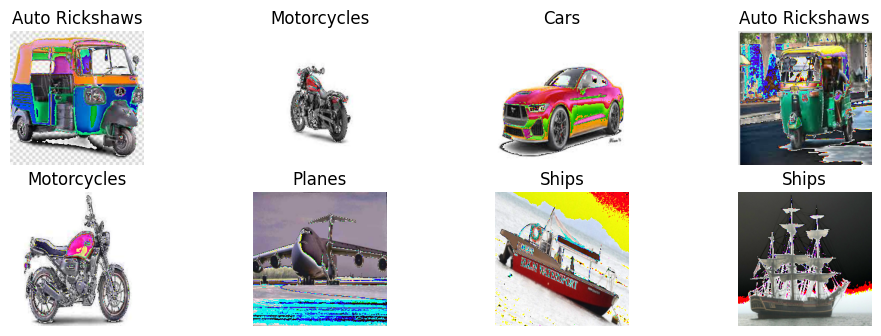

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.transforms.functional import to_pil_image
  
# Get class names
label_dict = {y: x for x, y in train_data.dataset.class_to_idx.items()} 
 
# Define a function to display images
def show_images(images, labels):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        image = to_pil_image(images[i])  # Convert tensor to PIL Image
        plt.imshow(image)
        plt.title(label_dict[labels[i].item()])  
        plt.axis('off')
    plt.show()
  
# Get the first batch
for batch_idx, (images, labels) in enumerate(train_set):
    if batch_idx == 0:  # Only process the first batch
        show_images(images, labels)
        break

<br>

## Model & Training

In [34]:
import torch.nn as nn
import torch.optim as optim
 
# CrossEntropyLoss 
loss_fn = nn.CrossEntropyLoss()  
# AdamW optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5)   
 
# Move model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
# add accuracy values to the list 
train_accuracies=[]
validation_accuracies=[]
 
# Function for training
def train(dataloader, model, loss_fn, optimizer, epoch):
    # Get total number of samples
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
 
    # Set model to training mode
    model.train()
 
    # Initialize variables
    train_loss, correct = 0, 0
 
    # Iterate over batches, process each batch separately
    for batch, (X, y) in enumerate(dataloader):
        
        # Move image and label tensors to the GPU for faster processing
        X, y = X.to(device), y.to(device)
  
        # make prediction and extract logits
        pred = model(X).logits
         
        # calculate loss
        loss = loss_fn(pred, y)
 
        # calculate gradients
        loss.backward()
        # update model parameters using gradients
        optimizer.step()
        # clear gradients
        optimizer.zero_grad()
  
        # Update training loss
        train_loss += loss.item()
  
        # Calculate training accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
      
    # loss and accuracy
    train_loss = train_loss / num_batches
    accuracy = 100 * correct / size
     
    train_accuracies.append(accuracy)
 
    print(f" Training Accuracy: {accuracy:.2f}%, Training Loss: {train_loss:.4f}")

In [35]:
# Function for validation
def validation(dataloader, model, loss_fn, epoch):
 
    # Get total number of samples
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
 
    # Initialize variables
    validation_loss, correct = 0, 0
 
    # !!!! Set model to evaluation mode, weights not updated
    model.eval()
 
    # Disable gradient calculation
    with torch.no_grad():
        for X, y in dataloader:
            # Move image and label tensors to the GPU for faster processing
            X, y = X.to(device), y.to(device)
             
            # extract logits
            pred = model(X).logits
 
            # Calculate validation loss and accuracy
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
 
    # Average validation loss and accuracy
    validation_loss /= num_batches
    accuracy = 100 * correct / size
  
    validation_accuracies.append(accuracy)
  
    print(f" Validation Accuracy: {accuracy:.2f}%, Validation Loss: {validation_loss:.4f}")

In [36]:
# epoch number 
epochs = 5
 
# loop for training model 
for t in range(epochs):
    print(f"Epoch {t+1}")
    train(train_set, model, loss_fn, optimizer, t) 
    validation(validation_set, model, loss_fn, t)
    print("----------------------------")
print("Done!")

Epoch 1
 Training Accuracy: 97.50%, Training Loss: 0.3121
 Validation Accuracy: 98.48%, Validation Loss: 0.0898
----------------------------
Epoch 2
 Training Accuracy: 99.75%, Training Loss: 0.0394
 Validation Accuracy: 99.37%, Validation Loss: 0.0424
----------------------------
Epoch 3
 Training Accuracy: 99.11%, Training Loss: 0.0467
 Validation Accuracy: 97.58%, Validation Loss: 0.0842
----------------------------
Epoch 4
 Training Accuracy: 99.78%, Training Loss: 0.0168
 Validation Accuracy: 98.66%, Validation Loss: 0.0587
----------------------------
Epoch 5
 Training Accuracy: 99.80%, Training Loss: 0.0116
 Validation Accuracy: 99.19%, Validation Loss: 0.0417
----------------------------
Done!


<br>

### Testing the Model

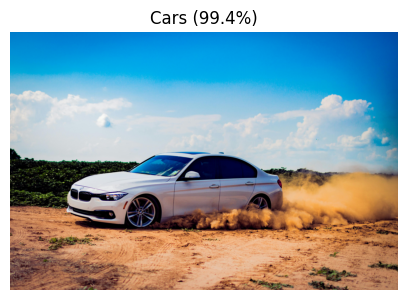

In [ ]:
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
 
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
# transform same as training
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])
 
# get class names from dataset
class_names = train_data.dataset.classes if isinstance(train_data, torch.utils.data.Subset) else train_data.classes
 
# path to single test image
image_path = r"test-images\pexels-trace-707046.jpg"  # change to your image path
 
# load and transform image
img = Image.open(image_path).convert("RGB")
input_tensor = predict_transform(img).unsqueeze(0).to(device)
 
# predict
model.eval()
with torch.no_grad():
    outputs = model(input_tensor).logits
    pred_class = outputs.argmax(1).item()
    prob = torch.softmax(outputs, dim=1)[0, pred_class].item()
 
# display image with predicted label
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(f"{class_names[pred_class]} ({prob*100:.1f}%)")
plt.axis("off")
plt.show()

<br><br><br><br>